In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import copy

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seed set to {SEED}.")

Random seed set to 42.


In [3]:
EPOCHS = 8
BATCH_SIZE = 64
LR = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Normalization values for 1-channel grayscale image
# (0.5,) for mean, (0.5,) for std deviation.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load the test data
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print("MNIST dataset loaded and transformed.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 997kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.57MB/s]

MNIST dataset loaded and transformed.
Number of training samples: 60000
Number of test samples: 10000
Image shape: torch.Size([1, 28, 28])


In [5]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"DataLoaders created with batch size {BATCH_SIZE}.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

DataLoaders created with batch size 64.
Number of training batches: 938
Number of testing batches: 157


In [6]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # Input shape: (Batch, 1, 28, 28)

        # Convolutional Layer 1
        # (1, 28, 28) -> (16, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        # (16, 28, 28) -> (16, 14, 14)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Convolutional Layer 2
        # (16, 14, 14) -> (32, 14, 14)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        # (32, 14, 14) -> (32, 7, 7)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layer
        # Flatten (32, 7, 7) to 32 * 7 * 7 = 1568
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10) # 10 output classes (0-9)

    def forward(self, x):
        # Conv 1 block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Conv 2 block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten the feature map
        # The -1 infers the batch size
        x = x.view(-1, 32 * 7 * 7)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x) # Output logits
        return x

model = MNIST_CNN()
print("Model architecture:")
print(model)

Model architecture:
MNIST_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
model = MNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Model, Loss Function (CrossEntropyLoss), and Optimizer (Adam) initialized.")
print(f"Model moved to {device}.")

Model, Loss Function (CrossEntropyLoss), and Optimizer (Adam) initialized.
Model moved to cpu.


In [8]:
# History tracking
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

best_test_accuracy = 0.0
best_model_weights = None

print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Move data to the selected device
        images, labels = images.to(device), labels.to(device)

        # 1. Zero the gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(images)

        # 3. Calculate loss
        loss = criterion(outputs, labels)

        # 4. Backward pass
        loss.backward()

        # 5. Update weights
        optimizer.step()

        # Track stats
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track stats
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_test_acc = correct_test / total_test
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    # Save the best model
    if epoch_test_acc > best_test_accuracy:
        best_test_accuracy = epoch_test_acc
        best_model_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc*100:.2f}% | "
          f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc*100:.2f}%")

print("Training finished.")

# Load the best model weights
model.load_state_dict(best_model_weights)
print(f"Best model weights loaded (Test Accuracy: {best_test_accuracy*100:.2f}%)")


Starting training for 8 epochs...
Epoch 1/8 | Train Loss: 0.1582 | Train Acc: 95.28% | Test Loss: 0.0445 | Test Acc: 98.58%
Epoch 2/8 | Train Loss: 0.0467 | Train Acc: 98.55% | Test Loss: 0.0339 | Test Acc: 98.84%
Epoch 3/8 | Train Loss: 0.0321 | Train Acc: 98.96% | Test Loss: 0.0370 | Test Acc: 98.78%
Epoch 4/8 | Train Loss: 0.0230 | Train Acc: 99.24% | Test Loss: 0.0323 | Test Acc: 98.91%
Epoch 5/8 | Train Loss: 0.0192 | Train Acc: 99.37% | Test Loss: 0.0294 | Test Acc: 99.08%
Epoch 6/8 | Train Loss: 0.0148 | Train Acc: 99.52% | Test Loss: 0.0413 | Test Acc: 98.84%
Epoch 7/8 | Train Loss: 0.0123 | Train Acc: 99.62% | Test Loss: 0.0314 | Test Acc: 99.14%
Epoch 8/8 | Train Loss: 0.0112 | Train Acc: 99.65% | Test Loss: 0.0355 | Test Acc: 99.00%
Training finished.
Best model weights loaded (Test Accuracy: 99.14%)


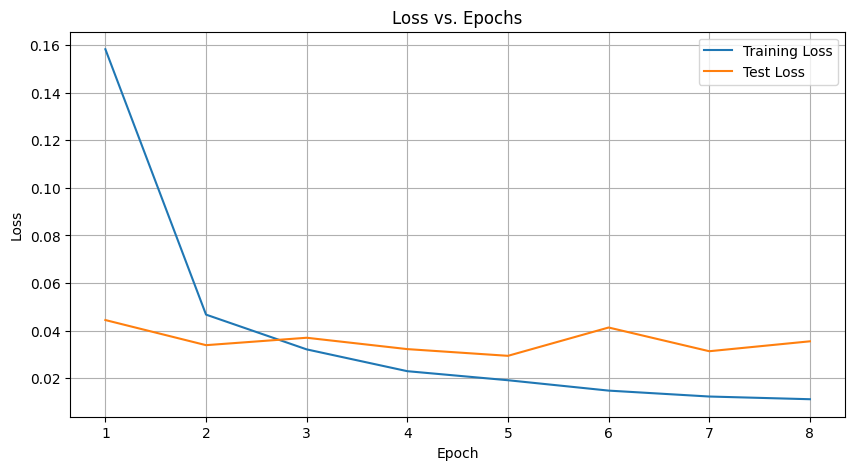

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

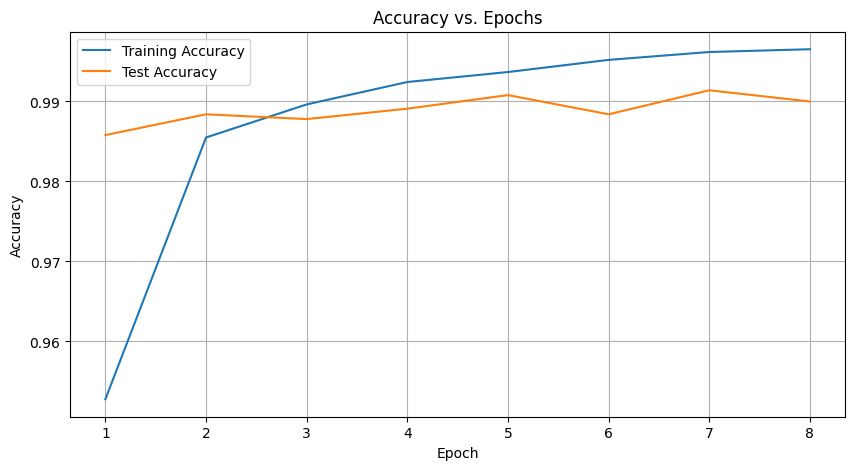

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

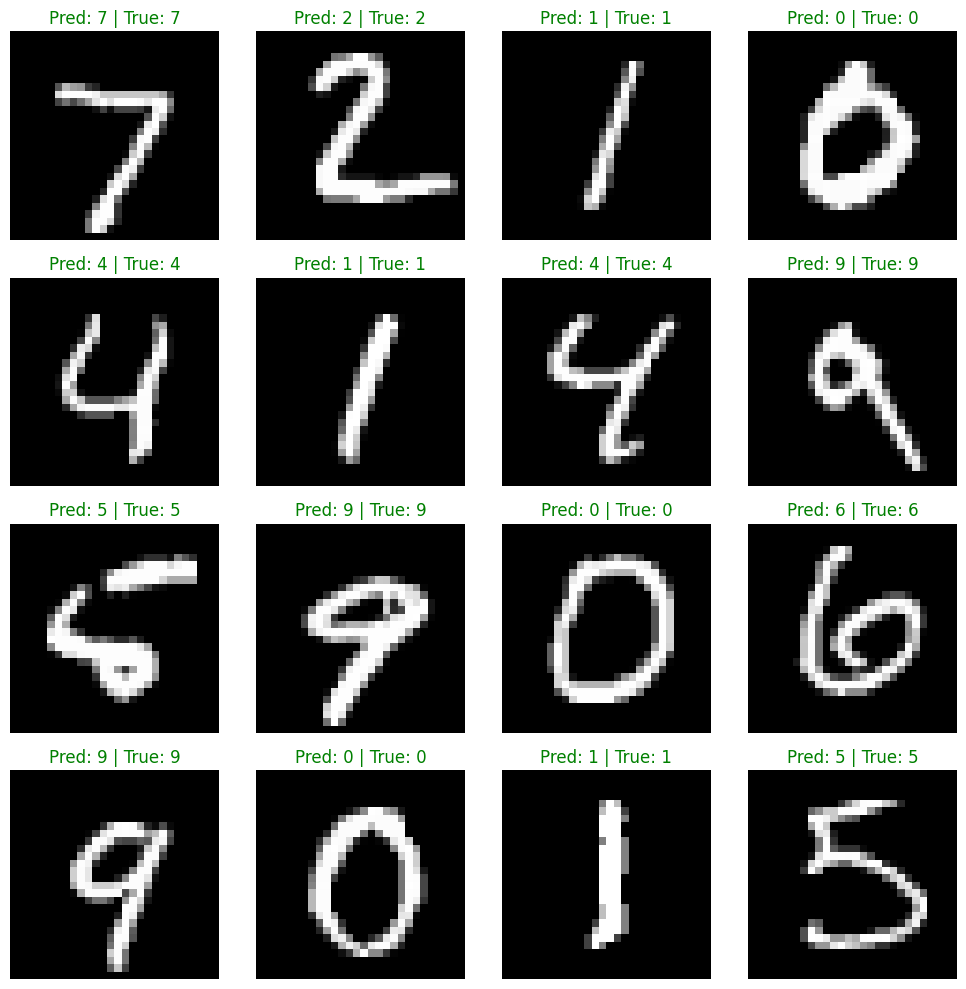

In [11]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Move data to CPU for plotting
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Un-normalize (from [-1, 1] to [0, 1])
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')

# Plot a grid of 16 images (4x4)
plt.figure(figsize=(10, 10))
for i in range(16):
    if i >= len(images): break
    plt.subplot(4, 4, i + 1)
    imshow(images[i])
    plt.title(f"Pred: {predicted[i].item()} | True: {labels[i].item()}",
              color=("green" if predicted[i] == labels[i] else "red"))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'\nFinal Accuracy on the {total} test images: {final_accuracy:.2f} %')


Final Accuracy on the 10000 test images: 99.14 %


In [13]:
MODEL_PATH = 'mnist_cnn_model.pth'
torch.save(model.state_dict(), MODEL_PATH)

print(f"\nModel state dictionary saved to {MODEL_PATH}")


Model state dictionary saved to mnist_cnn_model.pth
